<a href="https://colab.research.google.com/github/NatSy77/projet_7/blob/Ex-3-LigjtGBM-normalisation-du-cout-metier/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implémentez un modèle de scoring #modelisetion

In [ ]:
import gc
gc.collect()  # Collecte la mémoire non utilisée

20

## Importation

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install mlflow

In [ ]:
!pip install lightgbm

In [ ]:
#!pip install --upgrade threadpoolctl scikit-learn imbalanced-learn xgboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List files available
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/"))

['app_test.csv', 'app_train.csv']


In [ ]:
#importation fichier
app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False


In [ ]:
# Testing data features
app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 241)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,False,False,False,False,False,True,False,True,False,False
1,1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,False,False,False,False,True,False,False,True,False,False
4,4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,...,False,False,False,False,False,False,False,False,False,False


## Exploration

In [ ]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


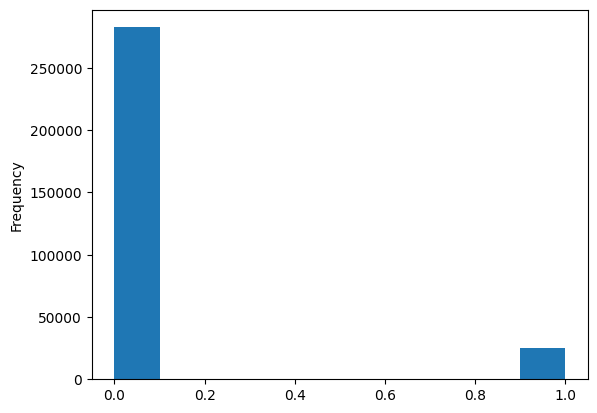

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

,count
bool,132
float64,66
int64,44


In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 241)


# Modélisation

### Préparation de l'environement

In [ ]:
!pip install mlflow pyngrok

In [ ]:
import os
from pyngrok import ngrok
import mlflow
import mlflow.sklearn  # Pour enregistrer les modèles scikit-learn

In [ ]:
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

### Chargement des données et préparation

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

train = train.drop(columns=['Unnamed: 0'], errors='ignore')

# Liste des noms des colonnes avant transformation
feature_names = train.columns.tolist()

# Vérification des valeurs manquantes et imputation si nécessaire
if train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    train = imputer.fit_transform(train)
    train = pd.DataFrame(train, columns=feature_names)  # Conserver les noms des features

# Division des données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

# Appliquer l'imputation sur les données de test
app_test = app_test.drop(columns=['Unnamed: 0', 'TARGET'], errors='ignore')  # Supprimer les colonnes en trop
# Réaligner les colonnes de `app_test` sur celles de `train`
app_test = app_test[feature_names]  # S'assurer qu'on a exactement les mêmes features
# Appliquer l'imputation
app_test = imputer.transform(app_test)
# Convertir en DataFrame pour conserver les noms des colonnes
app_test = pd.DataFrame(app_test, columns=feature_names)


# Vérification des noms de colonnes après transformation
print(f"Noms des features après transformation : {feature_names}")

Noms des features après transformation : ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVING

In [ ]:
"""from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

train = train.drop(columns=['Unnamed: 0'])

# Liste des noms des colonnes avant transformation
feature_names = train.columns.tolist()

# Vérification des valeurs manquantes
if train.isnull().sum().sum() > 0:
    # Créer un pipeline de prétraitement avec imputation et mise à l'échelle
    imputer = SimpleImputer(strategy='median')
    scaler = MinMaxScaler(feature_range=(0, 1))

    # On utilise ColumnTransformer pour appliquer les transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('imputer', imputer, feature_names),  # Imputation sur toutes les colonnes
            ('scaler', scaler, feature_names)  # Mise à l'échelle sur toutes les colonnes
        ]
    )

    # Appliquer le préprocesseur sur les données
    train = preprocessor.fit_transform(train)
else:
    train = train.values  # Si aucune valeur manquante, convertir en array numpy

# Diviser les données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

# Appliquer les mêmes transformations sur les données de test
# (Utilisez les mêmes imputer et scaler ajustés sur `train`)
app_test = app_test.drop(columns=['TARGET'], errors='ignore')  # Enlever la colonne TARGET si elle existe
app_test = preprocessor.transform(app_test)

# Vérification des noms de colonnes après transformation
feature_names_transformed = preprocessor.get_feature_names_out()

print(f"Noms des features après transformation : {feature_names_transformed}")"""

'from sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nimport pandas as pd\n\n# Chargement des données\nif \'TARGET\' in app_train.columns:\n    train = app_train.drop(columns=[\'TARGET\'])\n    target = app_train[\'TARGET\']\nelse:\n    train = app_train.copy()\n    target = None\n\ntrain = train.drop(columns=[\'Unnamed: 0\'])\n\n# Liste des noms des colonnes avant transformation\nfeature_names = train.columns.tolist()\n\n# Vérification des valeurs manquantes\nif train.isnull().sum().sum() > 0:\n    # Créer un pipeline de prétraitement avec imputation et mise à l\'échelle\n    imputer = SimpleImputer(strategy=\'median\')\n    scaler = MinMaxScaler(feature_range=(0, 1))\n\n    # On utilise ColumnTransformer pour appliquer les transformations\n    preprocessor = ColumnTransformer(\n        transformers=[\n        

### Initialisation de MLflow

In [ ]:
import mlflow
import os

# Créer le répertoire mlflow s'il n'existe pas
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

# Définir l'expérience
mlflow.set_experiment("Multi-Model Experiment lightgbm score metier")

#Model Experiment 3 LightGBM
#Multi-Model Experiment 2 class_weight='balanced'
#Multi-Model Experiment 1 SMOTE

<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/DS_projet_7/mlflow/706359919036996243'), creation_time=1737912440232, experiment_id='706359919036996243', last_update_time=1737912440232, lifecycle_stage='active', name='Multi-Model Experiment lightgbm score metier', tags={}>

In [ ]:
#input_example = np.array([X_train[1]])  # Exemple basé sur une ligne des données d'entraînement

In [ ]:
input_example = X_train.iloc[[1]].values  # Obtenir les valeurs de la deuxième ligne (index 1)

### Préparation des outils et des données
Cette première étape configure les outils nécessaires, notamment pour gérer les classes déséquilibrées avec SMOTE et pour normaliser les données.

In [ ]:
target.value_counts(normalize=True)  # Vérifie la proportion de chaque classe

,proportion
TARGET,
0,0.919271
1,0.080729


#### Gestion des classes
LightGBM gère très bien le déséquilibre des classes avec **scale_pos_weight**.
SMOTE est une alternative, mais il vaut mieux l’éviter si scale_pos_weight fonctionne bien.
Le paramètre is_unbalance=True n'est pas nécessaire car j'utilises scale_pos_weight.

il n'est pas recommandé pour LightGBM d'utiliser is_unbalance en même temps que scale_pos_weight, car cela peut entraîner un mauvais ajustement du modèle

### Ajout d’une pipeline et Optimisation des hyperparamètres
Créer une pipeline pour standardiser le traitement, sans SMOTE, la normalisation, pour le modèle.

Intégration de RandomizedSearchCV pour trouver les meilleurs hyperparamètres d’un modèle dans une pipeline.

In [ ]:
import time
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.sklearn import load_model, log_model
from joblib import Parallel, delayed
from sklearn.ensemble import HistGradientBoostingClassifier
# Calculer la proportion des classes
from collections import Counter
# Import the necessary class
from lightgbm import LGBMClassifier

#### hyperparamètres
- **learning_rate**	Contrôle la vitesse d'apprentissage du modèle (petite valeur = apprentissage lent mais stable, grande valeur = apprentissage rapide mais risque d'overfitting).
- **n_estimators**	Nombre total d'arbres dans le modèle (plus d'arbres = meilleure généralisation, mais plus de temps de calcul).
- **max_depth**	Profondeur maximale des arbres (évite l'overfitting, mais limite la capacité d'apprentissage). None pour laisser l'algorithme décider.
- **num_leaves**	Nombre maximal de feuilles par arbre (plus de feuilles = plus de complexité). Par défaut, 31 est souvent un bon compromis.
- **min_child_samples**	Nombre minimal d'échantillons requis dans un nœud pour qu'il soit divisé (évite le sur-ajustement).
- **subsample**	Fraction des données utilisées pour chaque arbre (empêche l'overfitting, aide la généralisation).
- **colsample_bytree**	Fraction des features utilisées pour chaque arbre (évite l'overfitting et accélère l'entraînement).
- **min_split_gain**	Gain minimum requis pour diviser un nœud (évite les splits inutiles).
- **lambda_l1**	Régularisation L1 (encourage la sparsité des poids pour éviter l'overfitting).
- **lambda_l2**	Régularisation L2 (évite les poids trop élevés pour stabiliser l'apprentissage).
- **scale_pos_weight**	Poids des classes pour gérer le déséquilibre (ex: si classe 1 est 10x plus rare, mettre 10).

**Je couvre les principaux paramètres qui influencent l'overfitting, la vitesse d’apprentissage, et l'équilibre des classes**

In [ ]:
# Calcul du poids des classes
class_counts = Counter(y_train)  # Compte des classes
y_train_negative = class_counts[0]  # Classe négative (majoritaire)
y_train_positive = class_counts[1]  # Classe positive (minoritaire)
scale_pos_weight = y_train_negative / y_train_positive  # Poids de la classe minoritaire

In [ ]:
# Dictionnaire des modèles avec leurs hyperparamètres
models_with_params = {
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),  # Suppression de is_unbalance=True
        "params": {  # ✅ Correction : "params" doit être une clé du dictionnaire
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [50, 100, 200, 300],
            'model__max_depth': [3, 5, 7, 10],
            'model__num_leaves': [20, 31, 50],
            'model__min_child_samples': [10, 20, 50],
            'model__subsample': [0.5, 0.6, 0.8],
            'model__colsample_bytree': [0.5, 0.6, 0.8],
            'model__min_split_gain': [0.0, 0.1, 0.2],
            'model__lambda_l1': [0.0, 0.1, 1.0],
            'model__lambda_l2': [0.0, 0.1, 1.0],
            'model__scale_pos_weight': [1, scale_pos_weight]
        }
    }
}

#### score métier

In [ ]:
from sklearn.metrics import confusion_matrix

def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1, normalize=True):
    """
    Calcul du coût métier basé sur le coût des erreurs.

    Args:
    y_true (array-like): Valeurs réelles (0 ou 1).
    y_pred (array-like): Prédictions du modèle (0 ou 1).
    cost_fn (int): Coût d'un faux négatif.
    cost_fp (int): Coût d'un faux positif.
    normalize (bool): Normaliser par le nombre total d'exemples.

    Returns:
    float: Coût total des erreurs (normalisé si demandé).
    """
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total
    total_cost = (cost_fp * fp) + (cost_fn * fn)

    # Normalisation
    if normalize:
        total_cost = total_cost / len(y_true)  # Diviser par le nombre total d'exemples

    return total_cost

#### feature_name

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Fonction pour convertir en DataFrame après imputation
def to_dataframe(X, feature_names):
    return pd.DataFrame(X, columns=feature_names)

# Sauvegarder les noms des features avant transformation
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else None

#### RandomizedSearchCV
RandomizedSearchCV est souvent plus efficace que GridSearchCV, car il permet d’explorer un large espace d’hyperparamètres avec moins de calculs.

- Avantages de RandomizedSearchCV :

Il teste un sous-ensemble aléatoire des combinaisons possibles, ce qui est beaucoup plus rapide que de tester toutes les combinaisons (GridSearchCV).
Il est idéal pour des modèles avec beaucoup d’hyperparamètres, comme LightGBM.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [ ]:
def train_pipeline(model_name, model, params, X_train, y_train):
    """
    Entraînement d'un pipeline avec RandomizedSearchCV.

    Args:
    - model_name (str) : Nom du modèle.
    - model : Modèle ML à entraîner.
    - params (dict) : Dictionnaire des hyperparamètres.
    - X_train (DataFrame) : Features d'entraînement.
    - y_train (Series) : Labels d'entraînement.

    Returns:
    - best_params (dict) : Meilleurs hyperparamètres trouvés.
    """

    print(f"\n Entraînement du pipeline pour {model_name}...")

    # Création du pipeline
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('to_dataframe', FunctionTransformer(lambda X: to_dataframe(X, feature_names))),
        ('model', model)
    ])

    # Initialisation de RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=20,  # Ajustable selon la puissance de calcul
        scoring='roc_auc',  # Optimisation du score ROC-AUC
        cv=3,  # Validation croisée sur 3 folds
        n_jobs=-1,  # Utilisation de tous les cœurs pour accélérer
        random_state=42,
        verbose=1  # Correction de l'erreur de syntaxe
    )

    try:
        # Entraîner le modèle
        random_search.fit(X_train, y_train)

        # Sauvegarde du meilleur modèle
        model_filename = f'pipeline_{model_name}.pkl'
        joblib.dump(random_search.best_estimator_, model_filename)
        print(f" Pipeline pour {model_name} sauvegardé sous {model_filename}")

        # Sauvegarde des résultats de la recherche
        results_df = pd.DataFrame(random_search.cv_results_)
        results_filename = f'results_{model_name}.csv'
        results_df.to_csv(results_filename, index=False)
        print(f" Résultats sauvegardés dans {results_filename}")

        return random_search.best_params_

    except Exception as e:
        print(f" Erreur lors de l'entraînement du pipeline pour {model_name} : {e}")
        return None

#### training

In [ ]:
import traceback  # Pour afficher les erreurs détaillées

if __name__ == "__main__":
    # Vérifier si les données existent dans l'environnement
    if "X_train" in locals() and "y_train" in locals():
        # Vérifier que X_train est un DataFrame et y_train une Series
        if isinstance(X_train, pd.DataFrame) and isinstance(y_train, pd.Series):
            if X_train.shape[0] != y_train.shape[0]:
                print("❌ Erreur : Le nombre d'exemples dans X_train et y_train ne correspond pas.")
            else:
                results = {}  # Stocker les meilleurs hyperparamètres
                errors = {}   # Stocker les erreurs éventuelles

                # Boucle sur les modèles pour entraînement
                for model_name, model_data in models_with_params.items():
                    print(f"\n🚀 Entraînement du modèle : {model_name}")

                    try:
                        # Exécuter le pipeline d'entraînement
                        best_params = train_pipeline(
                            model_name=model_name,
                            model=model_data["model"],
                            params=model_data["params"],
                            X_train=X_train,
                            y_train=y_train
                        )

                        # Stocker les meilleurs hyperparamètres trouvés
                        results[model_name] = best_params
                        print(f"✅ Meilleurs paramètres pour {model_name} : {best_params}")

                    except Exception as e:
                        print(f"❌ Erreur lors de l'entraînement de {model_name} : {e}")
                        errors[model_name] = str(e)
                        traceback.print_exc()  # Afficher l'erreur complète pour debug

                # Affichage des résultats finaux
                print("\n📊 Résultats finaux :")
                for model, params in results.items():
                    print(f"✅ {model}: {params}")

                # Affichage des erreurs (si présentes)
                if errors:
                    print("\n❌ Modèles ayant échoué :")
                    for model, error_msg in errors.items():
                        print(f"{model}: {error_msg}")

        else:
            print("❌ Erreur : X_train doit être un DataFrame et y_train une Series.")
    else:
        print("❌ Erreur : Les données d'entraînement (X_train, y_train) ne sont pas définies.")


🚀 Entraînement du modèle : LightGBM

 Entraînement du pipeline pour LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
 Erreur lors de l'entraînement du pipeline pour LightGBM : 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final

### Boucle sur plusieurs modèles avec journalisation MLflow
Cette étape inclut les modèles supplémentaires et enregistre chaque expérimentation dans MLflow.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
import shap
import gc

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.6.1


In [ ]:
# Charger les modèles optimisés après RandomizedSearchCV
models = {model_name: joblib.load(f'pipeline_{model_name}.pkl') for model_name in models_with_params}

In [ ]:
# Liste pour stocker les courbes ROC
roc_curves = []

In [ ]:
# Répertoire pour les sorties
output_dir = "mlflow_outputs"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Fonction pour convertir en DataFrame après imputation
def to_dataframe(X, feature_names):
    return pd.DataFrame(X, columns=feature_names)

# Sauvegarder les noms des features avant transformation
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else None

In [ ]:
# Boucle sur chaque modèle
for model_name, pipeline in models.items():
    start_time = time.time()

    try:
        print(f"\n🚀 Entraînement du modèle : {model_name}")

        # === Prédictions ===
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

        # === Calcul des métriques ===
        total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0.0

        # === Ajustement du seuil pour minimiser le coût personnalisé ===
        optimal_threshold = 0.5  # Valeur par défaut
        if y_prob is not None:
            thresholds = np.arange(0.1, 1.0, 0.05)
            costs = [custom_cost_function(y_test, (y_prob >= t).astype(int), cost_fn=10, cost_fp=1) for t in thresholds]

            if costs:
                optimal_threshold = thresholds[np.argmin(costs)]

        print(f"✅ Seuil optimal trouvé : {optimal_threshold}")

        # === MLflow : Enregistrement ===
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)

            # Enregistrer les métriques
            mlflow.log_metric("custom_cost", total_cost)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("auc_roc", auc_roc)
            mlflow.log_param("optimal_threshold", optimal_threshold)

            # Enregistrer le pipeline complet
            model_path = os.path.join(output_dir, f"{model_name}_pipeline.pkl")
            joblib.dump(pipeline, model_path)
            mlflow.log_artifact(model_path)

            # Journaliser la pipeline dans MLflow
            input_example = pd.DataFrame(X_train[:1]) if isinstance(X_train, np.ndarray) else X_train.iloc[:1]
            log_model(sk_model=pipeline, artifact_path="model_pipeline", input_example=input_example)

            # === Courbe ROC ===
            if y_prob is not None:
                plt.figure()
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.title(f'ROC Curve - {model_name}')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.legend(loc="lower right")
                roc_curve_path = os.path.join(output_dir, f"roc_curve_{model_name}.png")
                plt.savefig(roc_curve_path)
                plt.close()
                mlflow.log_artifact(roc_curve_path)

            # Enregistrer le temps d'exécution
            elapsed_time = time.time() - start_time
            mlflow.log_metric("training_time", elapsed_time)

        print(f"✅ Modèle {model_name} journalisé avec succès.")

    except Exception as e:
        print(f"❌ Erreur lors de l'entraînement du modèle {model_name}: {e}")


🚀 Entraînement du modèle : LightGBM
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
✅ Seuil optimal trouvé : 0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
✅ Modèle LightGBM journalisé avec succès.


### Lancer l'interface MLflow UI
Utilisation d'une interface web distante via ngrok(exposée au public), créer un compte et récupérer le token

In [ ]:
!ngrok authtoken 2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!mlflow ui --backend-store-uri "file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow" --port 5000 &

[2025-01-31 20:15:09 +0000] [38256] [INFO] Starting gunicorn 23.0.0
[2025-01-31 20:15:09 +0000] [38256] [INFO] Listening at: http://127.0.0.1:5000 (38256)
[2025-01-31 20:15:09 +0000] [38256] [INFO] Using worker: sync
[2025-01-31 20:15:09 +0000] [38257] [INFO] Booting worker with pid: 38257
[2025-01-31 20:15:09 +0000] [38258] [INFO] Booting worker with pid: 38258
[2025-01-31 20:15:09 +0000] [38259] [INFO] Booting worker with pid: 38259
[2025-01-31 20:15:09 +0000] [38260] [INFO] Booting worker with pid: 38260
[2025-01-31 20:15:54 +0000] [38256] [CRITICAL] WORKER TIMEOUT (pid:38259)
[2025-01-31 20:15:55 +0000] [38259] [ERROR] Error handling request /ajax-api/2.0/mlflow/runs/search
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gunicorn/workers/sync.py", line 134, in handle
    self.handle_request(listener, req, client, addr)
  File "/usr/local/lib/python3.11/dist-packages/gunicorn/workers/sync.py", line 177, in handle_request
    respiter = self.wsgi(en

In [ ]:
from pyngrok import conf, ngrok

# Définir le token dans la configuration
conf.get_default().auth_token = "2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU"

# Démarrer le tunnel
public_url = ngrok.connect(5000)
print(f"Interface MLflow accessible à : {public_url}")

Interface MLflow accessible à : NgrokTunnel: "https://0ee8-35-204-4-88.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# arrêter le tunnel ngrok
#ngrok.disconnect(public_url)

In [ ]:
# adresss local du modele
# file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/589125752895295283/ade1fabf29c549f4b76aa509f4391391/artifacts/LightGBM_pipeline.pkl

Metriques :
- **F1-Score**
Le F1-score est une métrique qui combine précision et rappel en un seul score harmonique. C'est utile lorsque vous avez un déséquilibre entre les classes, car il pénalise les modèles qui sacrifient l'une au profit de l'autre.

Utilisé lorsque les faux positifs (FP) et faux négatifs (FN) sont également importants.

- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**
L'AUC-ROC mesure la capacité d'un modèle à discriminer entre les classes positives et négatives, en testant différents seuils de probabilité.
Interprétation de l'AUC :
AUC = 1 : Parfaite séparation des classes.
AUC = 0.5 : Modèle aléatoire (aucune capacité de discrimination).
AUC < 0.5 : Mauvais modèle (inversion des classes).

Utile pour comparer des modèles indépendamment d'un seuil spécifique.

- **Précision (Precision)**
La précision mesure la proportion de vrais positifs parmi tous les échantillons prédits comme positifs.

Utile lorsque les faux positifs sont coûteux.

- **Rappel (Recall ou Sensibilité)**
Le rappel mesure la proportion de vrais positifs parmi tous les échantillons qui sont effectivement positifs.

- **Temps de calcul**
mesurer le temps de calcul de chaque modèle

Utile lorsque les faux négatifs sont coûteux.

Précision vs Rappel : Il existe souvent un compromis entre précision et rappel. Une augmentation de l'un peut réduire l'autre.
F1-Score : Trouve un équilibre entre précision et rappel.
AUC-ROC : Évalue la performance globale sur tous les seuils.

En utilisant ces prédictions :

* Précision : Parmi les clients que le modèle dit éligibles, combien le sont vraiment ?
* Rappel : Parmi les clients réellement éligibles, combien le modèle détecte-t-il ?
* F1-Score : Moyenne harmonique de la précision et du rappel.
* AUC-ROC : Mesure la capacité du modèle à distinguer entre les deux classes sur tous les seuils possibles.

Ces métriques permettent de choisir le modèle qui répond le mieux à vos objectifs métier et aux coûts associés aux erreurs de classification.

#### Analyse des résultats du modèle
Coût personnalisé :

Un coût de 32900 est relativement élevé, ce qui pourrait indiquer que des erreurs spécifiques (faux positifs ou faux négatifs) pèsent beaucoup dans votre fonction de coût.
Précision (accuracy, 0.6989) :

Une précision proche de 70 % est correcte mais peut être trompeuse si les classes sont déséquilibrées. Cela explique probablement pourquoi l'AUC ROC est plus significatif ici.
F1-score (0.2657) :

Un score F1 modéré, mais faible, indique que l'équilibre entre précision et rappel est difficile à atteindre. La faible précision (16,5 %) tire le score F1 vers le bas.
Rappel (0.6771) :

Un bon rappel (68 % environ) montre que le modèle identifie bien les cas positifs, mais il sacrifie de la précision pour y parvenir.
AUC ROC (0.7583) :

Un AUC supérieur à 0,75 est un bon signe que le modèle discrimine correctement entre les classes, malgré un déséquilibre.

chemin pipeline drive : file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/706359919036996243/6384c7a1e96c4d7088902ac022cd934c/artifacts/LightGBM_pipeline.pkl

import mlflow

model_uri = 'runs:/6384c7a1e96c4d7088902ac022cd934c/model_pipeline'
This is the input example logged with the model
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
input_data = pyfunc_model.input_example

 Verify the model with the provided input data using the logged dependencies.
 For more details, refer to:
 https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv",
)
Faire des prédictions
Prédire sur un DataFrame Pandas :
import mlflow
logged_model = 'runs:/6384c7a1e96c4d7088902ac022cd934c/model_pipeline'

 Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

 Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

coût_personnalisé
32900
précision
0,6989089963091232
f1_score
0,26574147501982553
précision
0,16531004883824182
rappel
0,67710648615882
auc_roc
0,7582520225949627
durée_de_formation
40.01733660697937